In this example, we train a model on the clock dataset:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pathlib

In [2]:
from energy_model.api import EnergyModel
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import RandomizedSearchCV, HalvingRandomSearchCV
from scipy.stats import poisson, expon, beta

In [3]:
from hpbandster_sklearn import HpBandSterSearchCV
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH

In [4]:
n_dim = 2

In [5]:
X = pd.read_csv("clock.csv", header=0, index_col=None)
X

,x,y
0,-1.260606,-0.000535
1,1.002662,-1.204463
2,-1.321710,-0.238404
3,0.762651,1.143736
4,-0.869301,1.350036
...,...,...
9995,0.727683,-1.128361
9996,-0.925200,0.966343
9997,1.255048,-0.153047
9998,-0.083234,1.226470


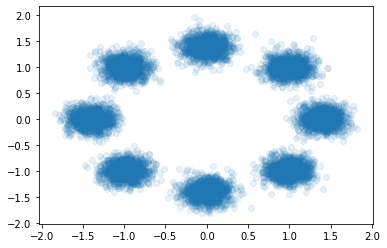

In [6]:
plt.scatter(X["x"], X["y"], alpha=0.1)

In [7]:
do_search="bohb"
warm = True

In [ ]:
clf = EnergyModel(
    n_dim,
    batch_size=5000,
    num_layers=3,
    num_units=32,
    weight_decay=3e-2,
    max_iter=10,
    num_mc_steps=300,
    replay_prob=0.96,
    sampler="langevin",
    lr=1e-1,
    sampler_lr=1e-1,
    prior_scale=10,
    adversary_weight=0.5
)
max_resources = 100
if do_search == "halving":
    distributions = dict(
        lr=expon(1e-2),
        sampler_lr=expon(1e-1),
        sampler=["mala", "langevin", "tempered mala", "tempered langevin"],
        weight_decay=expon(1e-3),
    #     max_iter=poisson(30),
        replay_prob=beta(a=9, b=1),
        adversary_weight=beta(a=1, b=1),
        num_units=poisson(32),
        num_layers=poisson(3),
        max_replay=poisson(10),
    )
    clf_cv = HalvingRandomSearchCV(
        clf, 
        distributions, 
        random_state=0, 
        n_jobs=5, 
        resource="max_iter", 
        max_resources=max_resources
    )
    search = clf_cv.fit(X.values)
    clf = clf_cv.best_estimator_
elif do_search == "bohb":
    distributions = CS.ConfigurationSpace(seed=42)
    distributions.add_hyperparameter(CSH.UniformFloatHyperparameter("lr", 1e-4, 3e-1, log=True, default_value=6e-3))
    distributions.add_hyperparameter(CSH.UniformFloatHyperparameter("sampler_lr", 1e-4, 3e-1, log=True, default_value=1e-3))
    distributions.add_hyperparameter(CSH.CategoricalHyperparameter("sampler", choices=["mala", "langevin", "tempered mala", "tempered langevin"]))
    distributions.add_hyperparameter(CSH.UniformFloatHyperparameter("weight_decay", 1e-4, 3e-1, log=True, default_value=5e-2))
    distributions.add_hyperparameter(CSH.UniformFloatHyperparameter("prior_scale", 1e-1, 10, log=True, default_value=1.12))
    distributions.add_hyperparameter(CSH.UniformFloatHyperparameter("replay_prob", 0, 1, default_value=0.75))
    distributions.add_hyperparameter(CSH.UniformFloatHyperparameter("adversary_weight", 0, 1, default_value=0.6))
    distributions.add_hyperparameter(CSH.UniformIntegerHyperparameter("num_units", 4, 32, default_value=16))
    distributions.add_hyperparameter(CSH.UniformIntegerHyperparameter("num_layers", 2, 4, default_value=3))
    distributions.add_hyperparameter(CSH.UniformIntegerHyperparameter("max_replay", 2, 20, default_value=10))
    
    results = pathlib.Path("bohb_results.pkl")
    if warm and results.exists():
        with results.open("rb") as fh:
            res = pickle.load(fh)

    clf_cv = HpBandSterSearchCV(
        clf, 
        distributions, 
        random_state=0, 
        n_jobs=6,
        resource_name='max_iter', # can be either 'n_samples' or a string corresponding to an estimator attribute, eg. 'n_estimators' for an ensemble
        resource_type=int, # if specified, the resource value will be cast to that type before being passed to the estimator, otherwise it will be derived automatically
        min_budget=1,
        max_budget=max_resources,
        refit=True,
        optimizer="bohb",
        previous_result=res
    )
    search = clf_cv.fit(X, y=None)
    clf = clf_cv.best_estimator_
    with results.open("wb") as fh:
        pickle.dump(search._res, fh)
else:
    clf.fit(X.values)

/Users/dlibland/miniconda3/envs/langevin_energy_model/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/dlibland/miniconda3/envs/langevin_energy_model/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/dlibland/miniconda3/envs/lang

{'num_inputs': 2, 'batch_size': 5000, 'num_layers': 3, 'num_units': 4, 'weight_decay': 0.003008281879774911, 'max_iter': 1, 'num_mc_steps': 300, 'replay_prob': 0.2587799816000169, 'sampler': 'tempered langevin', 'lr': 0.003392060513051209, 'sampler_lr': 0.04231391553569695, 'prior_scale': 6.586289317583113, 'adversary_weight': 0.6842330265121569, 'warm_start': True, 'n_jobs': 1, 'max_replay': 4}
{'num_inputs': 2, 'batch_size': 5000, 'num_layers': 3, 'num_units': 8, 'weight_decay': 0.0003138811601755823, 'max_iter': 1, 'num_mc_steps': 300, 'replay_prob': 0.05808361216819946, 'sampler': 'tempered langevin', 'lr': 0.20218499516556748, 'sampler_lr': 0.001446589487367412, 'prior_scale': 0.2051110418843398, 'adversary_weight': 0.3745401188473625, 'warm_start': True, 'n_jobs': 1, 'max_replay': 15}
{'num_inputs': 2, 'batch_size': 5000, 'num_layers': 4, 'num_units': 17, 'weight_decay': 0.00020309496639348267, 'max_iter': 1, 'num_mc_steps': 300, 'replay_prob': 0.9266588657937942, 'sampler': 'tem

on epoch 0, batch 0, data erf: -0.9047476649284363, objective: -1.4551076889038086
model energy: 7.925336837768555 +- 1.2334767580032349
data energy: 6.470229148864746
training time: 4.886s, metrics time: 0.000s
on epoch 0, batch 0, data erf: -0.8094078898429871, objective: -0.8162188529968262
model energy: 7.147021293640137 +- 0.8819390535354614
data energy: 6.3308024406433105
training time: 2.174s, metrics time: 0.000s
on epoch 0, batch 0, data erf: -0.9845339059829712, objective: -5.845731258392334
model energy: 12.037979125976562 +- 3.4143600463867188
data energy: 6.1922478675842285
training time: 5.118s, metrics time: 0.000s
on epoch 0, batch 0, data erf: -0.7917661070823669, objective: -0.8255162239074707
model energy: 7.296868801116943 +- 0.9277035593986511
data energy: 6.471352577209473
training time: 2.334s, metrics time: 0.000s
on epoch 0, batch 0, data erf: -0.8131643533706665, objective: -0.8436970710754395
model energy: 7.34506893157959 +- 0.9039163589477539
data energy: 6

In [ ]:
search.best_params_

In [ ]:
samples = clf.sample(1000)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X["x"], X["y"], alpha=0.1)
ax.scatter(samples[:, 0], samples[:, 1], alpha=0.1)

In [ ]:
fig.savefig("clock.png")

In [ ]:
cols = ["energy_diff", "energy_coef", "data_erf", "adversary_cost"]
logs = pd.DataFrame({k:v for k,v in clf.logger_.full_logs.items() if k in cols})

In [ ]:
logs["energy_coef"].apply(np.log).plot()

In [ ]:
logs[[c for c in cols if c != "energy_diff"]].plot()